# Mixed lubrication modelling by the semi system approach
Slippy contains the powerful unified Reynold’s solver which can solve a wide variety of lubrication problems from Hertzian contact/ boundary lubrication to mixed lubrication and full EHL contacts. This can be done for non-Newtonian fluids including user defined or built-in models and rough surfaces. Using sub models for wear, friction, flash temperature, tribofilm growth, etc. full simulations can be carried out with any user defined behaviour.

Clearly this is a powerful and flexible tool. In this notebook, we will use this solver to solve the oil lubricated contact between a ball and a plane. This process has the steps defined below:
- Import slippy
- Solve the Hertzian contact problem as an initial guess for the solution and to set sensible bounds for the solution domain
- Make the surfaces
- Assign materials to the surfaces
- Make the lubricant and assign non-Newtonian sub models to it
- Make a contact model with the surfaces and the lubricant
- Make a Reynold’s solver object
- Make a lubrication model step with the Reynold’s solver
- Add this step to the contact model
- Data check the contact model
- Solve the contact model
- Analyse the result

In [1]:
# Importing slippy
import slippy
slippy.CUDA = False
import slippy.surface as S
import slippy.contact as C

# Defining constants
The next cell contains all the constants which we will use in the model, these can be edited for different situations:

In [2]:
radius = 0.01905       # The radius of the ball
load = 800             # The load on the ball in N
rolling_speed = 4      # The rolling speed in m/s (The mean speed of the surfaces)
youngs_modulus = 200e9 # The youngs modulus of the surfaces
p_ratio = 0.3          # The poission's ratio of the surfaces
grid_size = 65         # The number of points in the descretisation grid
eta_0 = 0.096          # Coefficient in the roelands pressure-viscosity equation
roelands_p_0 = 1/5.1e-9# Coefficient in the roelands pressure-viscosity equation
roelands_z = 0.68      # Coefficient in the roelands pressure-viscosity equation

# Solving the Hertzian problem
Slippy contains a comprehensive hertz solver that will provide all the parameters we need to initialise the solution. This can be found in the contact sub package:

In [3]:
# Solving the hertzian contact
hertz_result = C.hertz_full([radius, radius], [float('inf'), float('inf')], 
                            [youngs_modulus, youngs_modulus], 
                            [p_ratio, p_ratio], load)
hertz_pressure = hertz_result['max_pressure']
hertz_a = hertz_result['contact_radii'][0]
hertz_deflection = hertz_result['total_deflection']
hertz_pressure_function = hertz_result['pressure_f']

# Making the surface objects
Next, we will make define the geometry of the contacting surfaces. We can use analytically defined surfaces for this. In any contact model the 'master' surface must be discretised to the resolution of the solution grid. We can discretise the round surface to the correct grid size by setting its shape and extent and setting generate to True when the surface is made.

We can view the surface profile by calling the show() method on the surface.

<AxesSubplot:title={'center':'Surface profile'}, xlabel='x', ylabel='y'>

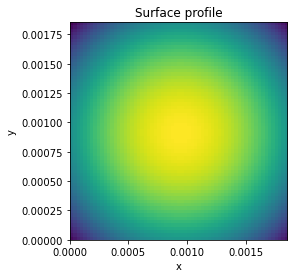

In [4]:
ball = S.RoundSurface((radius,)*3, shape = (grid_size, grid_size), 
                      extent=(hertz_a*4,hertz_a*4), generate = True)
flat = S.FlatSurface()
ball.show()

# Assigning materials to the surfaces
Now we must define how the surfaces deflect under load. This is done by setting the material property of the surfaces. If we wanted to model pure HDL, we could set theses to rigid materials, but here we will model full EHL by using an elastic material.

Any material object that supplies a displacement_from_surface_loads method can be used here.

In [5]:
steel = C.Elastic('steel', {'E' : youngs_modulus, 'v' : p_ratio})
ball.material = steel
flat.material = steel

# Making the lubricant
Now we must define how the lubricant flows under pressure and any non-Newtonian behaviour that we want to model. Our lubricant must have sub models for each of the fluid parameters in our chosen Reynold’s solver's requires property. In this case that is the non-dimensional viscosity and the non-dimensional pressure. If any of the needed models are missed it will be caught in the data check stage.

Here we will add a Roeland’s model for the viscosity and a Dowson Higginson model for the density. These are defined as shown below:

Roeland's:
$$\frac{\eta(P)}{\eta_0} = exp\left(\left(ln(\eta_0)+9.67\right)\left(-1+\left(1+\frac{P p_h}{p_0}\right)^z\right)\right)$$


In which $P$ is the non dimensional pressure, $\frac{\eta(P)}{\eta_0}$ is the non dimensional viscosity, $p_h$ is the Hertzian pressure and $p_o$, $\eta_0$ are parameters specific to each oil.

Dowson-Higginson:
$$\frac{\rho(P)}{\rho_0} = \frac{5.9e8+1.34p_hP}{5.9e8+p_hP}$$

In which $P$ is the non dimensional pressure, $\frac{\rho(P)}{\rho_0}$ is the non dimensional density, and $p_h$ is the Hertzian pressure and $\rho_0$ is the density at ambient pressure.

**Sub models added to the lubricant will be run on every iteration of the solver. Models for wear or friction etc should be added to the step or the contact model, these are run on each step after the normal contact has been solved.**

In [6]:
print(C.UnifiedReynoldsSolver.requires) # looking at the requires property of our chosen solver

oil = C.Lubricant('oil') # Making a lubricant object to contain our sub models
oil.add_sub_model('nd_viscosity', C.lubricant_models.nd_roelands(eta_0, roelands_p_0, hertz_pressure, roelands_z))
oil.add_sub_model('nd_density', C.lubricant_models.nd_dowson_higginson(hertz_pressure)) # adding dowson higginson

{'nd_density', 'nd_pressure', 'nd_viscosity', 'nd_gap'}


# Making a contact model
Now we will make a contact model to coordinate solving our steps, contact models can contain any number of solution steps to be solved. They also handle file output for long simulations. For our single step simulation, we do not need file outputs.

The first argument of the contact model is the name, this will be used for the log file and the output files. The second argument is the master surface, this must be discretised.

In [7]:
my_model = C.ContactModel('lubrication_test', ball, flat, oil)

# Making a Reynold’s solver
There are many ways to solve a Reynold’s equation, as such Reynold’s solvers are separate object in slippy. The Reynold’s solver you choose will depend on the situation you are trying to model but these can be used interchangeably in the lubrication steps. 

Our Reynold’s solver is non dimensional and as such must take all the parameters which are used to non-denationalise the problem, the exact parameters needed will change from solver to solver, the documentation for your particular solver should be consulted.

In [8]:
reynolds = C.UnifiedReynoldsSolver(time_step = 0,
                                   grid_spacing = ball.grid_spacing,
                                   hertzian_pressure = hertz_pressure,
                                   radius_in_rolling_direction=radius,
                                   hertzian_half_width=hertz_a,
                                   dimentional_viscosity=eta_0,
                                   dimentional_density=872)

# Making a lubrication step and adding it to the model
The unified Reynold’s solver only solves the fluid pressure problem. To solve the full EHL problem we need to use this with a model step. This step coordinates solving each of the semi systems (fluid pressure, material deflection, pressure-viscosity, pressure-density) as well as checking for convergence in the solution. 

To make the solution converge faster we can provide an initial guess of the pressure distribution from the Hertzian solution we found earlier. We can also add any options which we want to pass to the material objects, and iteration controls like the required accuracy, the maximum number of iterations and the relaxation factor used for the pressure result.

Lastly, we need to add this step to our contact model.

In [9]:
# Find the hertzian pressure distribution as an initial guess
X, Y = ball.get_points_from_extent()
X, Y = X + ball._total_shift[0], Y + ball._total_shift[1]
hertzian_pressure_dist = hertz_pressure_function(X, Y)

# Making the step object
step = C.IterSemiSystem('main', reynolds, rolling_speed, 1, no_time=True, normal_load=load,
                        initial_guess=[hertz_deflection, hertzian_pressure_dist],
                        relaxation_factor=0.05, max_it_interference=3000)

# Adding the step to the contact model
my_model.add_step(step)

C:\Users\mea08\code\SlipPY\slippy\contact\lubrication_steps.py:221: UserWarning: Nothing set to update
  warnings.warn("Nothing set to update")


# Data checking the model
There are many potential problems that can arise during solution of a contact model. data checking the model will ensure that during the solution each requirement of all the sub models, Reynold’s solvers, steps, and outputs will be fulfilled when they are called. A model failing to write your required outputs can waste a lot of time, so it is always best not to skip this step.

*It will not ensure that your result will converge or that the result will resemble reality in any way. For this you must validate against experimental measurements, tinker with iteration controls or do some maths (hopefully not).*

In [10]:
my_model.data_check()

Data check started at:
11:53:24 14-01-2021
Checking model lubrication_test:
Checking step: main
Checking sub models for step main
Checking outputs for step main


# Solving the model
Now we are ready to solve the model! 

This is easy, by default the solve method will return the final state of the model as a dict, it will also write all requested outputs to a file.

In [11]:
state = my_model.solve()
print(f"Result converged: {state['converged']}")

Result converged: True


# Plotting our results
To plot our results we need to import some plotting packages

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Full pressure distribution

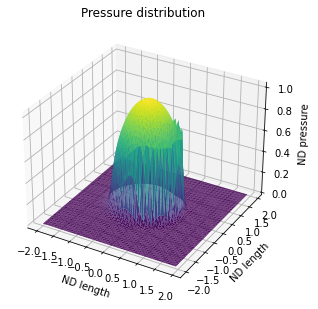

In [13]:
fig = plt.figure(figsize=(8,5))
ax = fig.gca(projection='3d')
ax.plot_trisurf(X.flatten()/hertz_a, Y.flatten()/hertz_a, state['nd_pressure'].flatten(), 
                cmap=plt.cm.viridis, linewidth=0.2)
ax.set_xlabel('ND length')
ax.set_ylabel('ND length')
ax.set_zlabel('ND pressure')
ax.set_title('Pressure distribution')
plt.show()

# Gap

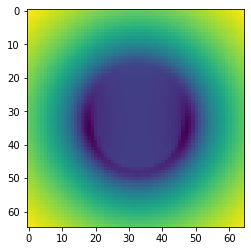

In [14]:
state['gap'][state['gap']<0.5e-9] = 0.5e-9 
plt.imshow(np.log(state['gap']))

# Central pressure distribution

Text(0.5, 1.0, 'Central pressure distribution')

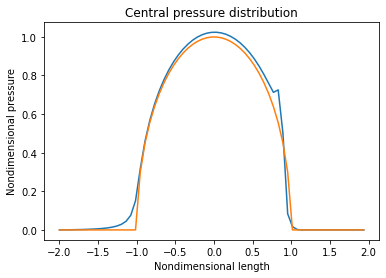

In [15]:
plt.plot(X[:,0]/hertz_a,state['nd_pressure'][:,32], label='Lubricated')
plt.plot(X[:,0]/hertz_a,hertzian_pressure_dist[:,32]/hertz_pressure, label='Hertz')
ax = plt.gca()
ax.set_xlabel('Nondimensional length')
ax.set_ylabel('Nondimensional pressure')
ax.set_title('Central pressure distribution')

# Central film thickness

Text(0.5, 1.0, 'Central film thickness')

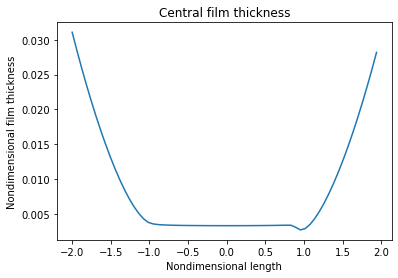

In [16]:
plt.plot(X[:,0]/hertz_a, state['gap'][:,32]/hertz_a)
ax = plt.gca()
ax.set_xlabel('Nondimensional length')
ax.set_ylabel('Nondimensional film thickness')
ax.set_title('Central film thickness')